# Gridded NetCDF modelresults

2D modelresults stored in NetCDF or Grib can be loaded to ModelSkill using xarray. In this way, MIKE 21 modelresults in dfsu format can easily be compared to model results from third party providers often stored in NetCDF. 

In [1]:
import xarray as xr
import modelskill as ms

## Observations

In [2]:
o1 = ms.PointObservation('../tests/testdata/SW/HKNA_Hm0.dfs0', item=0, x=4.2420, y=52.6887, name="HKNA")
o2 = ms.PointObservation("../tests/testdata/SW/eur_Hm0.dfs0", item=0, x=3.2760, y=51.9990, name="EPL")
o3 = ms.TrackObservation("../tests/testdata/SW/Alti_c2_Dutch.dfs0", item=3, name="c2")

## MIKE ModelResult

In [3]:
mrMIKE = ms.model_result('../tests/testdata/SW/HKZN_local_2017_DutchCoast.dfsu', name='MIKE21SW', item=0)

## NetCDF ModelResult

In [4]:
fn = "../tests/testdata/SW/ERA5_DutchCoast.nc"
xr.open_dataset(fn)

<xarray.Dataset> Size: 590kB
Dimensions:    (longitude: 20, latitude: 11, time: 67)
Coordinates:
  * longitude  (longitude) float32 80B -1.0 -0.5 0.0 0.5 1.0 ... 7.0 7.5 8.0 8.5
  * latitude   (latitude) float32 44B 55.0 54.5 54.0 53.5 ... 51.0 50.5 50.0
  * time       (time) datetime64[ns] 536B 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    mwd        (time, latitude, longitude) float64 118kB ...
    mwp        (time, latitude, longitude) float64 118kB ...
    mp2        (time, latitude, longitude) float64 118kB ...
    pp1d       (time, latitude, longitude) float64 118kB ...
    swh        (time, latitude, longitude) float64 118kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [5]:
mrERA5 = ms.model_result(fn, item="swh", name='ERA5')

In [6]:
mrERA5

<GridModelResult>: ERA5
Time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00
Quantity: Significant height of combined wind waves and swell [m]

In [7]:
mrERA5.data  # mr contains the xr.Dataset

<xarray.Dataset> Size: 119kB
Dimensions:  (time: 67, y: 11, x: 20)
Coordinates:
  * x        (x) float32 80B -1.0 -0.5 0.0 0.5 1.0 1.5 ... 6.5 7.0 7.5 8.0 8.5
  * y        (y) float32 44B 55.0 54.5 54.0 53.5 53.0 ... 51.5 51.0 50.5 50.0
  * time     (time) datetime64[ns] 536B 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    swh      (time, y, x) float64 118kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

## Test extract from XArray

1) Extract point 
2) Extract track

In [8]:
mrERA5.extract(o1, spatial_method="nearest").data.head()

<xarray.Dataset> Size: 104B
Dimensions:  (time: 5)
Coordinates:
  * time     (time) datetime64[ns] 40B 2017-10-27 ... 2017-10-27T04:00:00
    x        float64 8B 4.242
    y        float64 8B 52.69
    z        object 8B None
Data variables:
    ERA5     (time) float64 40B 1.22 1.347 1.466 1.612 1.793
Attributes:
    gtype:               point
    modelskill_version:  1.2.dev0

In [9]:
mrERA5.extract(o3).data.head()

<xarray.Dataset> Size: 168B
Dimensions:  (time: 5)
Coordinates:
    x        (time) float64 40B 2.423 2.414 2.405 2.396 2.387
    y        (time) float64 40B 51.25 51.31 51.37 51.42 51.48
  * time     (time) datetime64[ns] 40B 2017-10-27T12:52:52.337000 ... 2017-10...
    z        float64 8B nan
Data variables:
    ERA5     (time) float64 40B 1.439 1.464 1.489 1.514 1.538
Attributes:
    gtype:               track
    modelskill_version:  1.2.dev0

## Multi-file ModelResult

Use mfdataset to load multiple files as a single ModelResult.

In [10]:
fn = "../tests/testdata/SW/CMEMS_DutchCoast_*.nc"
mrCMEMS = ms.model_result(fn, item="VHM0", name='CMEMS')
mrCMEMS

<GridModelResult>: CMEMS
Time: 2017-10-28 00:00:00 - 2017-10-29 18:00:00
Quantity: Spectral significant wave height (Hm0) [m]

## Grib file ModelResult

In [11]:
fn = r"../tests/testdata/SW/NWW3_hs_201710.grib"

In [12]:
#mr3 = ModelResult(fn, name='WW3', engine='cfgrib') # not yet supported

## Connect multiple models and observations and extract

<Axes: >

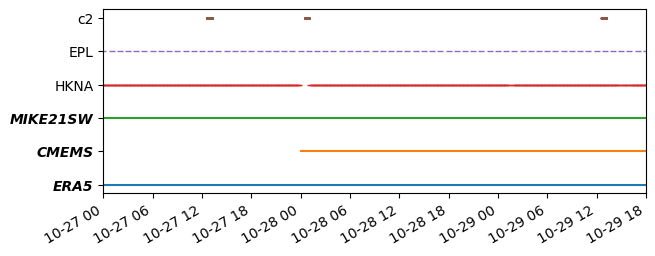

In [13]:
ms.plotting.temporal_coverage(obs=[o1,o2,o3], mod=[mrERA5, mrCMEMS, mrMIKE])

In [14]:
# o1 is slightly outside the model domain of mrERA5, 
# we therefore use "nearest" instead of the default spatial interpolation method  
cc = ms.match(
    obs=[o1, o2, o3], 
    mod=[mrERA5, mrCMEMS, mrMIKE], 
    spatial_method='nearest',
)

## Analysis and plotting
Which model is better? 

In [15]:
sk = cc.skill()
sk.swaplevel().sort_index(level="observation").style()

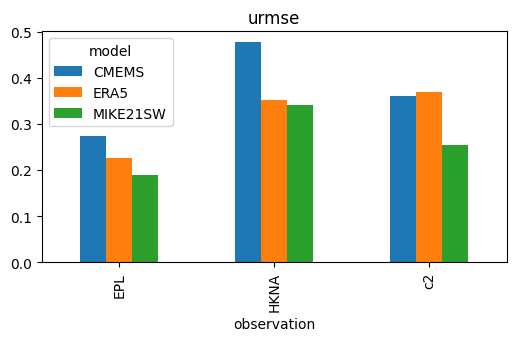

In [16]:
sk["urmse"].plot.bar(figsize=(6,3));

In [17]:
cc.mean_skill().style()

,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,
CMEMS,321,-0.461,0.604,0.370,0.508,0.918,0.103,0.491
ERA5,321,-0.446,0.547,0.315,0.466,0.951,0.088,0.618
MIKE21SW,321,0.002,0.340,0.262,0.273,0.962,0.073,0.852


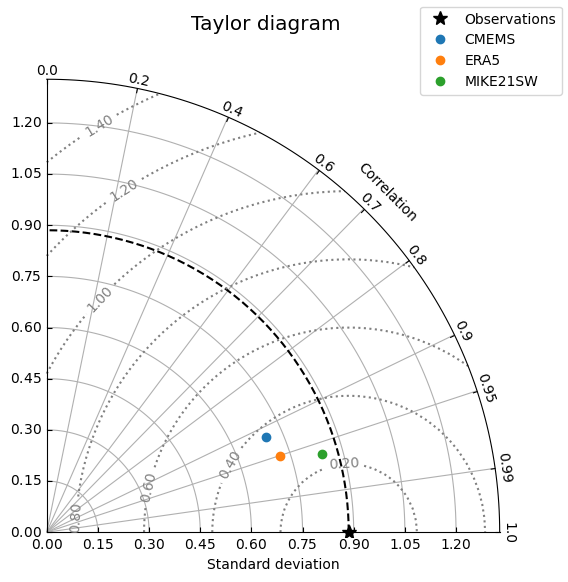

In [ ]:
cc.plot.taylor(figsize=(6,6))